In [1]:
import sys
sys.path.insert(0,"..")
import torch, gc
from torch.utils.data import SubsetRandomSampler
import matplotlib.pyplot as plt
from PIL import Image
from numpy import uint8

from src.dataset import ImageDataset
from src.utils import get_indices, plot_loss, psnr
from src.loss_functions import FFTloss, VGGPerceptualLoss

from mwcnn import MWCNN
from training import MWCNNTrainer

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
gc.collect()
torch.cuda.empty_cache()

# Dataset part used for testing
VALIDATION_SPLIT = 0.15
# Batch size for training. Limited by GPU memory
BATCH_SIZE = 2
# Full Dataset path
TEST_DATASETS = ['val']
TRAIN_DATASETS = ['train']
ROOTDIR = '../data/'

# Training Epochs
EPOCHS = 100

IMAGESIZE = 1024

gc.collect()
torch.cuda.empty_cache()

/home/jurri/miniconda3/lib/python3.11/site-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
/home/jurri/miniconda3/lib/python3.11/site-packages/torchvision/transforms/v2/__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may hav

## 1 Initiate train and test loader

In [2]:
train_image_dataset = ImageDataset(ROOTDIR, TRAIN_DATASETS, normalize="minmax", image_size=IMAGESIZE)
train_indices, validation_indices = get_indices(len(train_image_dataset), train_image_dataset.root_dir, VALIDATION_SPLIT, new=True)
train_sampler, validation_sampler = SubsetRandomSampler(train_indices), SubsetRandomSampler(validation_indices)

trainloader = torch.utils.data.DataLoader(train_image_dataset, BATCH_SIZE, sampler=train_sampler)
validationloader = torch.utils.data.DataLoader(train_image_dataset, BATCH_SIZE, sampler=validation_sampler)

test_image_dataset = ImageDataset(ROOTDIR, TEST_DATASETS, normalize="minmax", image_size=IMAGESIZE)
testloader = torch.utils.data.DataLoader(test_image_dataset, 1)

/home/jurri/miniconda3/lib/python3.11/site-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `transforms.Compose([transforms.ToImageTensor(), transforms.ConvertImageDtype()])`.
  warnings.warn(


## 1.1 Show example of images

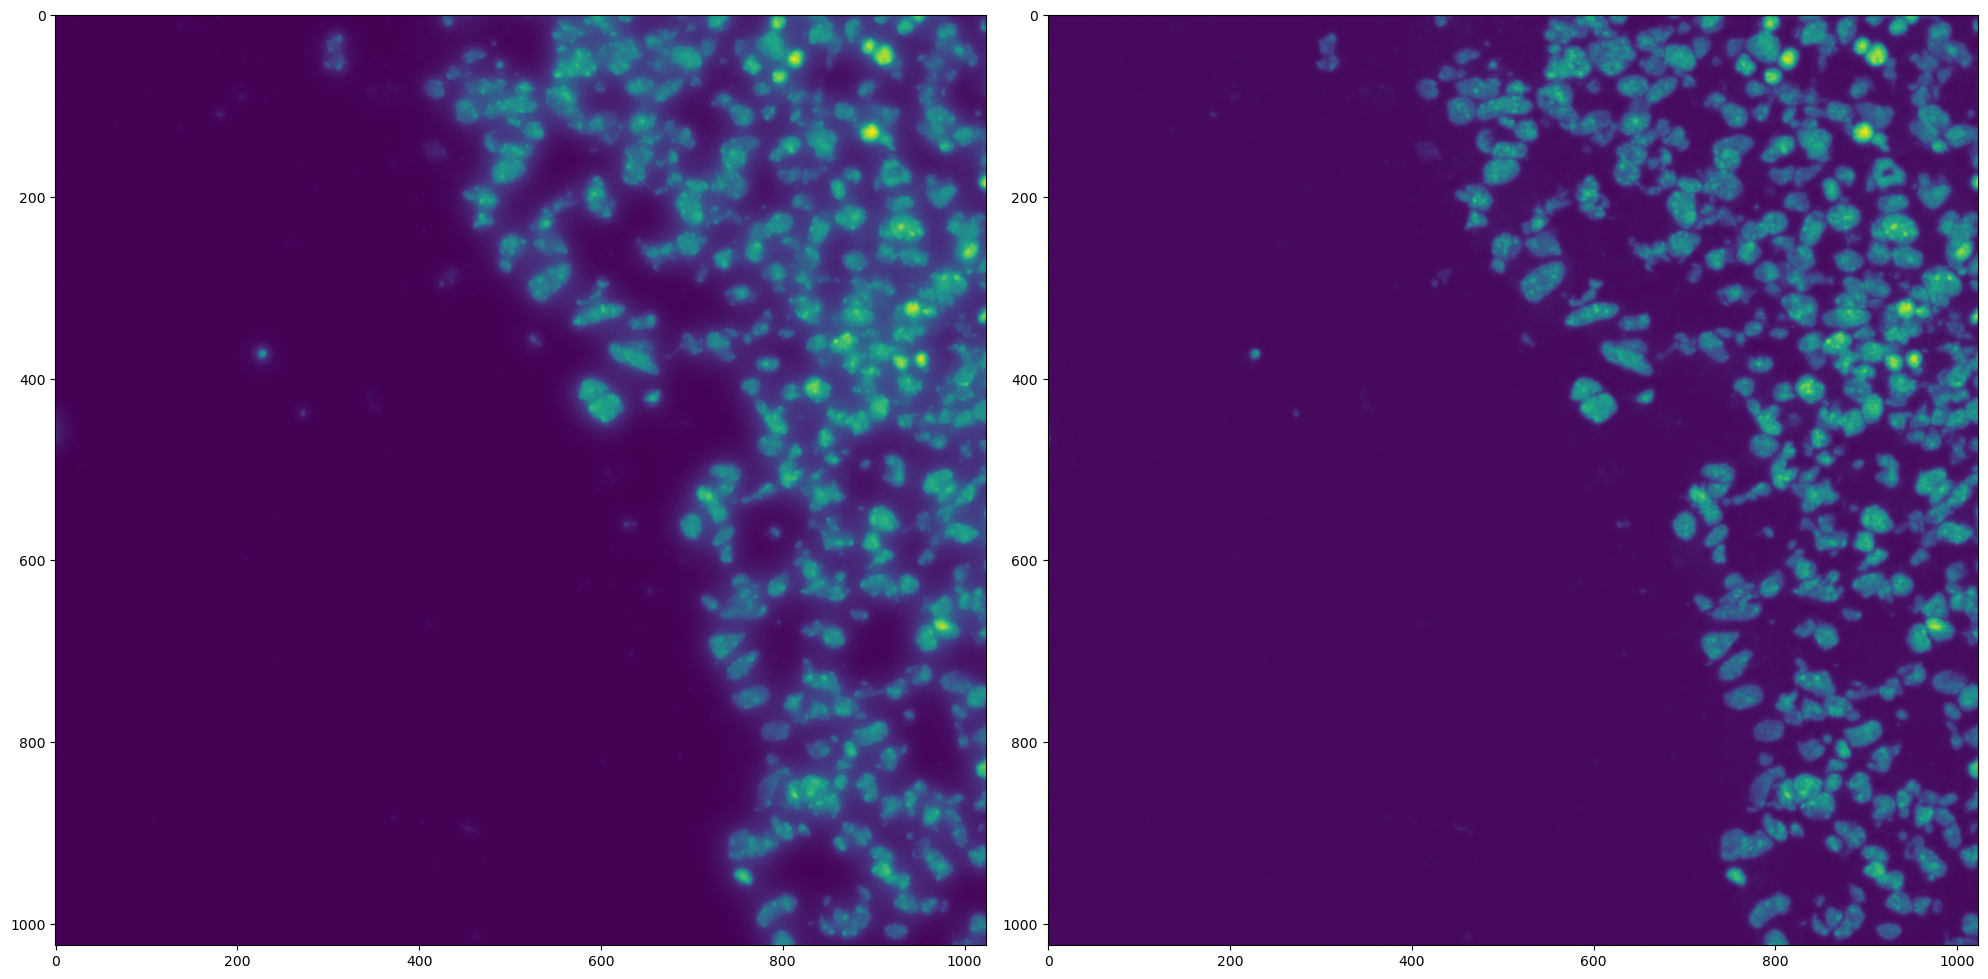

In [3]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 60))
image_index = 10
sample = train_image_dataset[image_index]

ax[0].imshow(sample["input_image"].squeeze(), aspect='equal')
ax[1].imshow(sample["output_image"].squeeze(), aspect='equal')

plt.tight_layout()
plt.show()

## 2 Initiate models

In [5]:
N_FEATS = 32
learning_rate=1e-3
local_criterion = torch.nn.L1Loss()
global_criteria = [FFTloss(device=device, han_window=True), None]
global_criteria_scale = [0.0001, None]
names = ["fft", "none"]
results = []
for criterion, scale, name in zip(global_criteria, global_criteria_scale, names):
    # Create model
    MWCNN_model = MWCNN(n_feats=N_FEATS, n_colors=1, batch_normalize=True).to(device)
    # Initialize trainer
    MWCNN_trainer = MWCNNTrainer(
        MWCNN_model, learning_rate= learning_rate, model_file=f"{name}_mwcnn_feats_{N_FEATS}.pth",
        local_criterion=local_criterion, global_criterion=criterion, 
        scale=scale, device=device)
    # Do training
    train_loss_record, validation_loss = MWCNN_trainer.train(EPOCHS,trainloader, validationloader)
    # save losses
    results.append({"loss_func": name, "train_loss": train_loss_record, "validation_loss": validation_loss})

    

Starting Training Process
Epoch: 001,  Train Loss:15.0601168,  Validation Loss:4.3702176,  Epoch: 002,  Train Loss:8.4377031,  Validation Loss:38.1839789,  Epoch: 003,  Train Loss:6.4282816,  Validation Loss:9.1310411,  Epoch: 004,  Train Loss:4.1899404,  Validation Loss:5.4486500,  Epoch: 005,  Train Loss:3.4167979,  Validation Loss:16.8256558,  Epoch: 006,  Train Loss:3.0468538,  Validation Loss:3.8007140,  Epoch: 007,  Train Loss:2.1706733,  Validation Loss:2.0062522,  Epoch: 008,  Train Loss:1.7840962,  Validation Loss:2.4873457,  Epoch: 009,  Train Loss:1.9298588,  Validation Loss:1.3556043,  Epoch: 010,  Train Loss:1.8234395,  Validation Loss:2.3424637,  Epoch: 011,  Train Loss:1.5323645,  Validation Loss:1.7717676,  Epoch: 012,  Train Loss:1.5727565,  Validation Loss:1.5113353,  Epoch: 013,  Train Loss:1.6016784,  Validation Loss:1.3227708,  Epoch: 014,  Train Loss:1.4396226,  Validation Loss:1.3268473,  Epoch: 015,  Train Loss:1.6593394,  Validation Loss:1.6072385,  Epoch: 016,

## Plot the losses

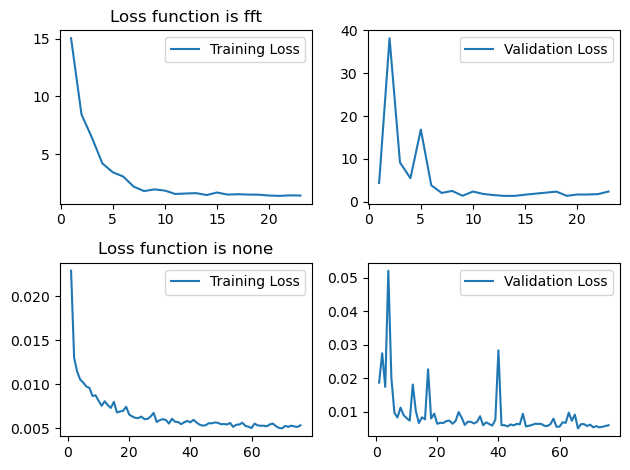

In [8]:
fig, ax = plt.subplots(nrows=2,ncols=2)
for i, result in enumerate(results):
    num_epochs = len(result["train_loss"])
    ax[i,0].plot(range(1, num_epochs + 1), result["train_loss"], label='Training Loss')
    ax[i,0].set_title(f"Loss function is {result['loss_func']}")
    ax[i,0].legend()
    ax[i,1].plot(range(1, num_epochs + 1), result["validation_loss"], label='Validation Loss')
    ax[i,1].legend()
plt.tight_layout()